In [6]:
import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import functions as f

import pandas as pd
import numpy as np

#splits
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report

#model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression


# Project Description

# Project Goal
* Discover drivers of outcome
* Use drivers of outcomes to develop machine learning models to predict outcomes

# Initial Thoughts

* Our initial hypothesis is that the drivers of outcome will be breed, age, condition, species, and sex.

## Acquire
* The data was aquired on `10 July 2023`
* Two datasets downloaded from data.austintexas.gov: [Intake Dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) & [Outcome Dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238)
* Intake Dataset: 153,077 rows and 12 columns 
* Outcome Dataset: 153,449 row and 12 columns
* Each row represents an animal's case
* Each column represents features of the animal

## Prepare
- Two dataframes were created, model_df with encoded variables
- Altered column names for readability, and convenience
- Dropped nulls, duplicate ids, species other than cats and dogs
- Converted data types of various columns to appropriate ones such as 'dates' from string to datetime
- Columns were renamed
- Added Features: sex, breed, condition, outcome_age, rel_month, rel_year, primary_color, is_tabby, mix_color 
- Removed Features: id, name_x, monthyear_x, animal type_x, sex upon intake, age upon outcome, breed_x, color_x, monthyear_y, found location, age upon intake, outcome subtype, intake_datetime, outcome_datetime, outcome_date, intake_date
- Split data into train, validate and test (approx. 60/20/20), stratifying on 'outcome'
- Outliers were not adressed as they were part of the target


In [7]:
# # acquire and join dfs
# df = w.left_join_csv("austin_animal_outcomes.csv","austin_animal_center_intakes.csv", "df")

In [8]:
# #pulling in prepare function from functions.py, creating two dataframes, "df" and "model_df"
# df, model_df = w.prep_df(df)

# df.head()

# # pre exploration split: train, validate test
# train, validate, test = w.split_data(df, 'outcome')

In [9]:
model_df = pd.read_csv("model_df.csv")
model_df = model_df.drop(columns=["Unnamed: 0"])

In [10]:
df = pd.read_csv("df.csv")
df = df.drop(columns=["Unnamed: 0"])
train, validate, test = w.split_data(df, 'outcome')

train -> (66040, 14), 60.0%
validate -> (22014, 14),20.0%
test -> (22014, 14), 20.0%


### Sneak Peak at the Data


In [11]:
# overview of data
train.head()

dob   outcome            sex  name      intake_type  \
35226  2019-05-01  adoption  neutered male     1            stray   
76034  2014-08-30     other    intact male     1            stray   
9744   2019-04-06  adoption  neutered male     1  owner surrender   
83191  2013-02-11  adoption  neutered male     1            stray   
3040   2020-12-15  adoption  spayed female     1            stray   

               condition species       breed  outcome_age rel_month  rel_year  \
35226             normal     cat         mix          112       aug      2019   
76034  medical attention     cat         mix           19       sep      2014   
9744              normal     dog         mix         1468       apr      2023   
83191             normal     dog  two breeds         1146       apr      2016   
3040              normal     dog         mix          562       jun      2022   

      primary_color  is_tabby  mix_color  
35226         black         0          1  
76034         brown         1          1  
9744            tan         0          1  
83191         brown         0          1  
3040          black         0          1

# Exploration

* Confidence Interval: 95%

### Exploratory Questions: 
- Is Month Related to Outcome?
- Is Breed Related to Outcome?
- Is Sex Related to Outcome?
- Is Species Related to Outcome?
- Is Condition Related to Outcome

### What is the Percentage of Dogs and Cats?
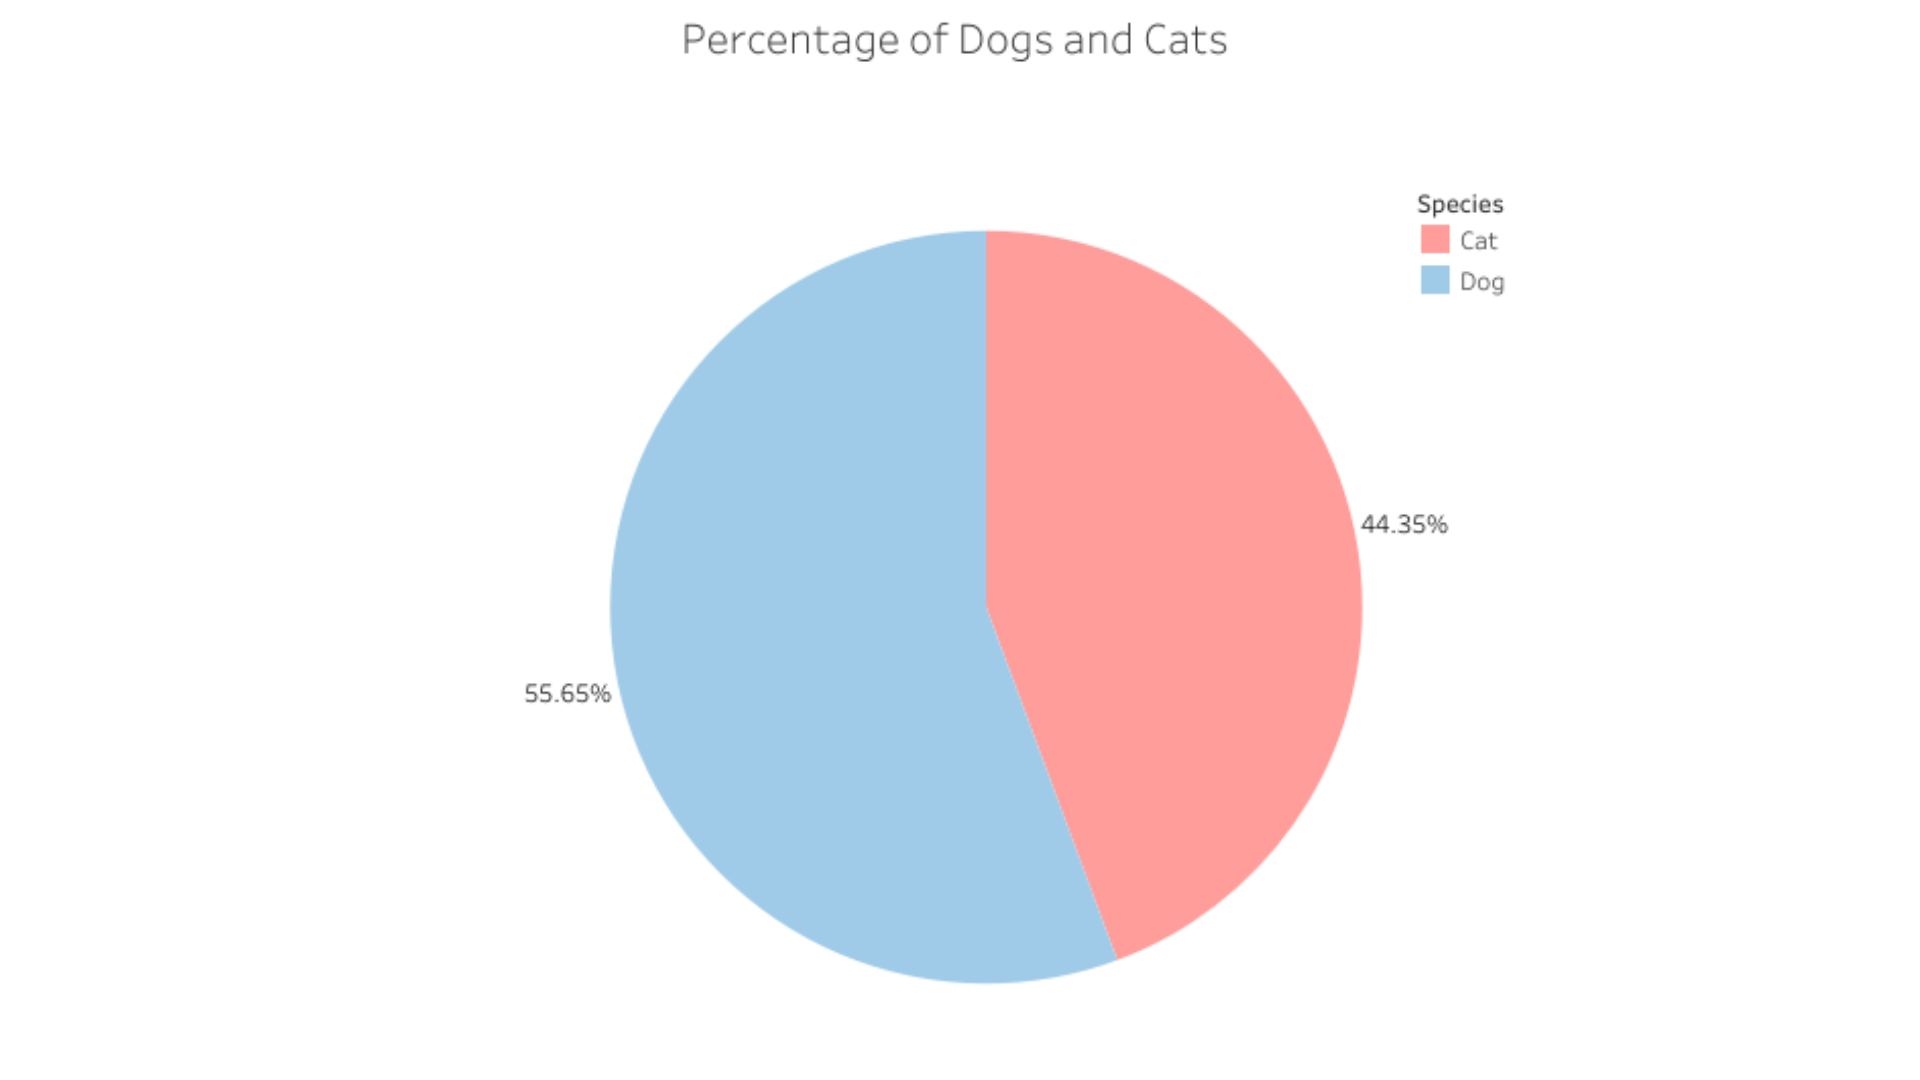

### Percentage of Dogs an Cats that Are Adopted?
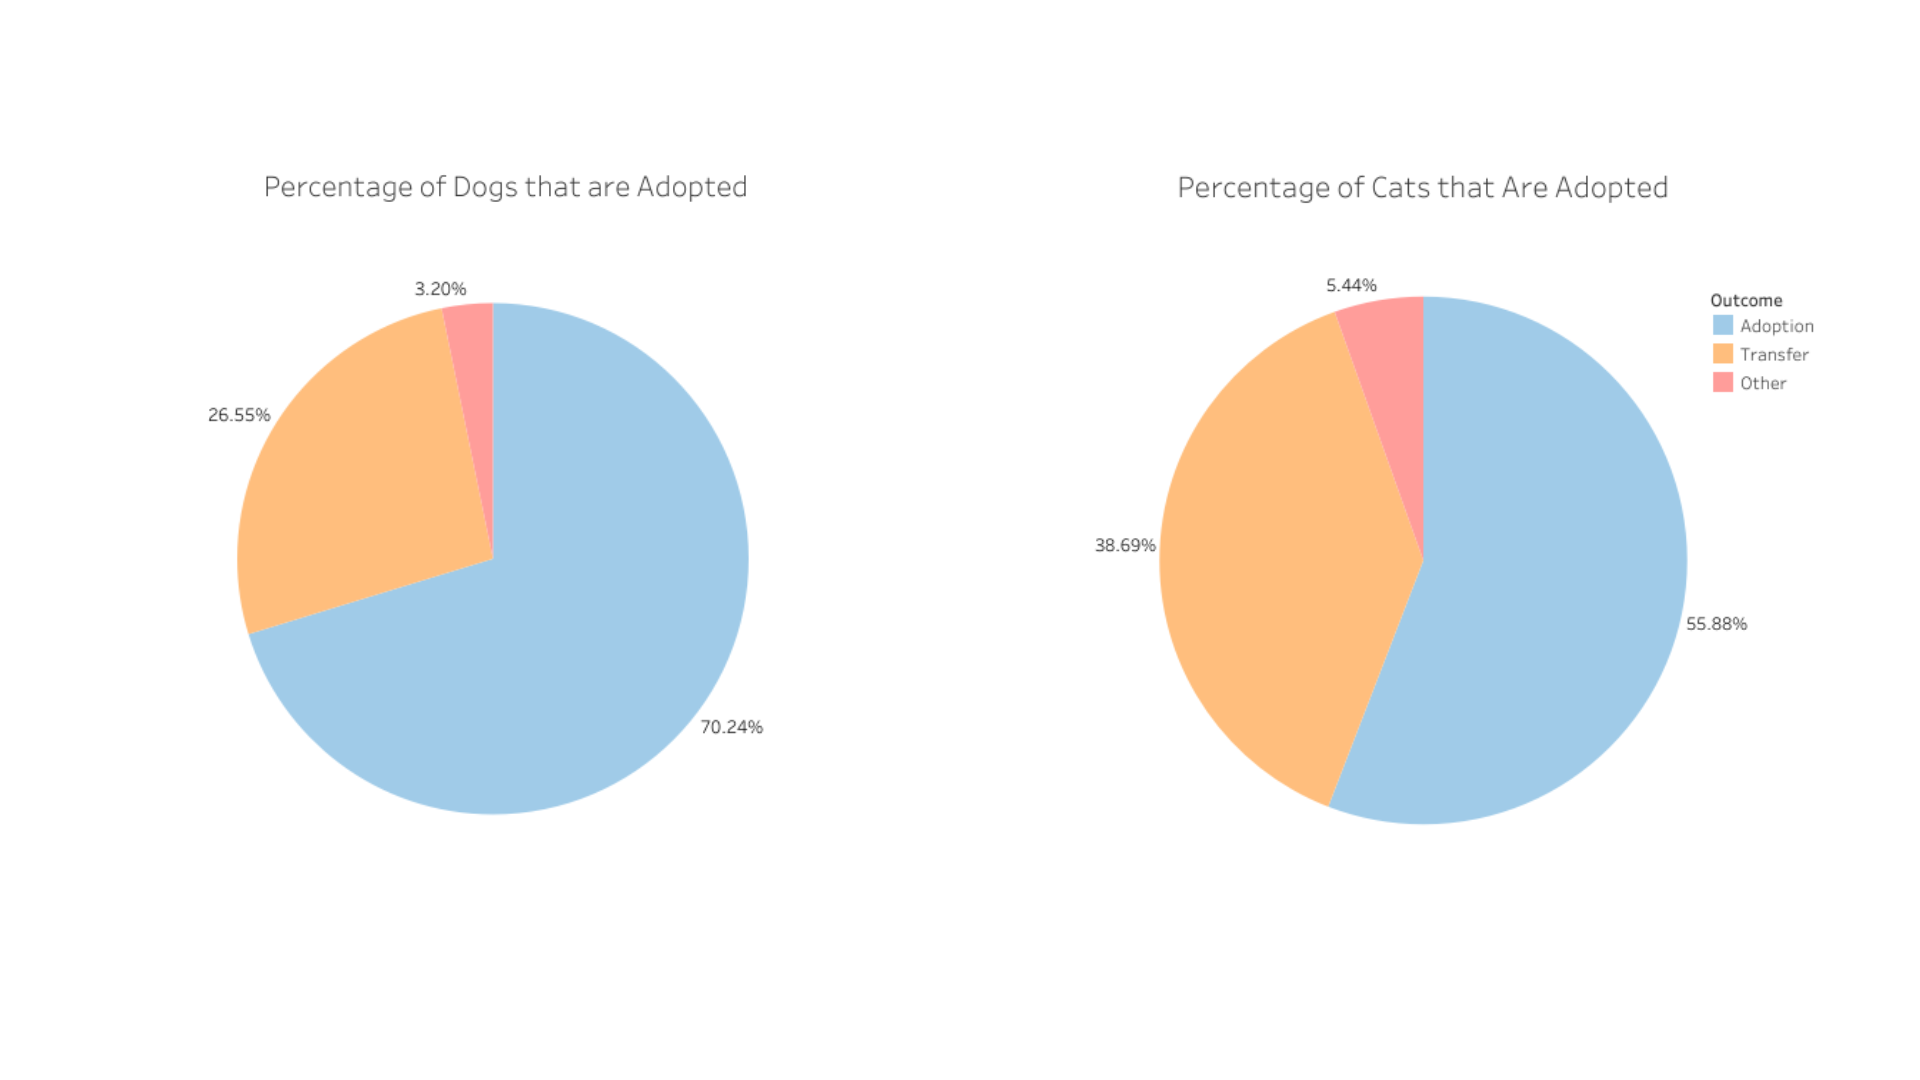

### Q 1. Is Month Related to Outcome?

* $Ho$ = There is no relationship between month and outcome.
* $Ha$ = There is a relationship between month and outcome.

In [25]:
import plotly.express as px
import plotly.graph_objects as go
def month_viz(train, target):
    '''
    This function pulls in a chart comparing sex and outcome using plotly express
    '''
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    train['rel_month'] = pd.Categorical(train['rel_month'], categories=month_order, ordered=True)
    grouped_data = train.groupby(['rel_month', 'outcome']).size().reset_index(name='count')
    grouped_data.sort_values('rel_month', inplace=True)
    fig = px.bar(grouped_data, x='rel_month', y='count', color='outcome', barmode='group')
        # Calculate the total count for each 'rel_month' category
    total_counts = grouped_data.groupby('rel_month')['count'].transform('sum')

    # Calculate the percentage of each 'outcome' category within each 'rel_month' category
    grouped_data['percentage'] = grouped_data['count'] / total_counts * 100

    # Create the stacked bar chart with percentages
    fig = px.bar(grouped_data, x='rel_month', y='percentage', color='outcome', barmode='group',
                 labels={'percentage': 'Total Percentage (%)'})

    # Set x-axis title
    fig.update_xaxes(title_text='Month')
    # Calculate the overall percentage of adoption & transfer line
    overall_adoption_percentage = train[train[target] == 'adoption'].shape[0] / train.shape[0] * 100
    overall_transfer_percentage = train[train[target] == 'transfer'].shape[0] / train.shape[0] * 100
    overall_other_percentage = train[train[target] == 'other'].shape[0] / train.shape[0] * 100
    
    #Add the average line for overall adoption percentage
    fig.add_hline(y=overall_adoption_percentage, line_dash='dash', line_color='blue',
#                   annotation_text=f'Avg. Adoption ({overall_adoption_percentage:.2f}%)',
#                   annotation_position='top right'
                 )

    # Add the average line for overall transferred percentage
    fig.add_hline(y=overall_transfer_percentage, line_dash='dash', line_color='green',
#                   annotation_text=f'Avg. Transferred ({overall_transfer_percentage:.2f}%)',
#                   annotation_position='top right'
                 )
    # Add the average line for overall other percentage
    fig.add_hline(y=overall_other_percentage, line_dash='dash', line_color='red',
#                   annotation_text=f'Avg. Other ({overall_other_percentage:.2f}%)',
#                   annotation_position='top right'
                 )
    # Set x-axis title
    fig.update_xaxes(title_text="Month")
  # Update layout to set the title
    # Update legend labels
    for trace in fig.data:
        if 'name' in trace:
            trace['name'] = str(trace['name']).capitalize()
        # Add invisible dummy traces to the plot for the legend
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='blue', dash='dash'), name='Avg. Adoption'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green', dash='dash'), name='Avg. Transferred'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', dash='dash'), name='Avg. Other'))
    # Capitalize words in the legend box titles
    fig.update_layout(legend_title_text='Outcome')
    fig.update_layout(plot_bgcolor = "rgba(0,0,0,0)", xaxis=dict(showgrid=False), yaxis=dict(showgrid=False, title='Winter Has More Adoptions'))  # Update layout to set the title
    fig.show(renderer='png')

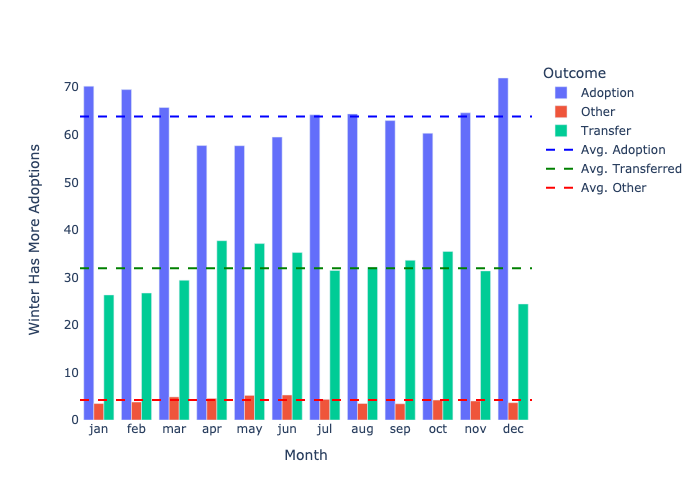

In [26]:
month_viz(train, "outcome")

In [ ]:
f.chi_stats(train, "rel_month", "outcome")

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* There is a higher volume of overall outcomes that occurred in June, July, August, and December



*Based on the result of our test and the observations in the chart, we can infer that month has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q 2. Is Breed Related to Outcome?

* $Ho$ = There is no relationship between breed and outcome.
* $Ha$ = There is a relationship between breed and outcome.

In [37]:
def px_viz(train, feature, target, ax_name, title_name):
    '''
    This function pulls in a chart comparing sex and outcome using plotly express
    '''
    # Calculate the count of each outcome within each species category
    grouped_data = train.groupby([feature, target]).size().reset_index(name='count')

    # Calculate the total count for each species category to get percentages
    species_total_counts = grouped_data.groupby(feature)['count'].transform('sum')
    grouped_data['percentage'] = grouped_data['count'] / species_total_counts * 100

    # Calculate the overall percentage of adoption & transfer line
    overall_adoption_percentage = train[train[target] == 'adoption'].shape[0] / train.shape[0] * 100
    overall_transfer_percentage = train[train[target] == 'transfer'].shape[0] / train.shape[0] * 100
    overall_other_percentage = train[train[target] == 'other'].shape[0] / train.shape[0] * 100
    
    # Convert  column to uppercase
    grouped_data[feature] = grouped_data[feature].str.capitalize()

    # Create the stacked bar chart
    fig = px.bar(grouped_data, x=feature, y='percentage', color=target, barmode='group',
                 labels={'percentage': 'Total Percentage (%)'})

    #Add the average line for overall adoption percentage
    fig.add_hline(y=overall_adoption_percentage, line_dash='dash', line_color='blue',
#                   annotation_text=f'Avg. Adoption ({overall_adoption_percentage:.2f}%)',
#                   annotation_position='top left'
                 )

    # Add the average line for overall transferred percentage
    fig.add_hline(y=overall_transfer_percentage, line_dash='dash', line_color='green',
#                   annotation_text=f'Avg. Transferred ({overall_transfer_percentage:.2f}%)',
#                   annotation_position='top left'
                 )
    # Add the average line for overall other percentage
    fig.add_hline(y=overall_other_percentage, line_dash='dash', line_color='red',
#                   annotation_text=f'Avg. Other ({overall_other_percentage:.2f}%)',
#                   annotation_position='top left'
                 )
    # Set x-axis title
    fig.update_xaxes(title_text=ax_name)
    fig.update_layout(title=title_name)  # Update layout to set the title
    # Update legend labels
    for trace in fig.data:
        if 'name' in trace:
            trace['name'] = str(trace['name']).capitalize()
        # Add invisible dummy traces to the plot for the legend
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='blue', dash='dash'), name='Avg. Adoption'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='green', dash='dash'), name='Avg. Transferred'))
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='red', dash='dash'), name='Avg. Other'))
    # Capitalize words in the legend box titles
    fig.update_layout(legend_title_text='Outcome')

    fig.update_layout(plot_bgcolor = "rgba(0,0,0,0)", xaxis=dict(showgrid=False),
              yaxis=dict(showgrid=False))

    fig.show(renderer='png')

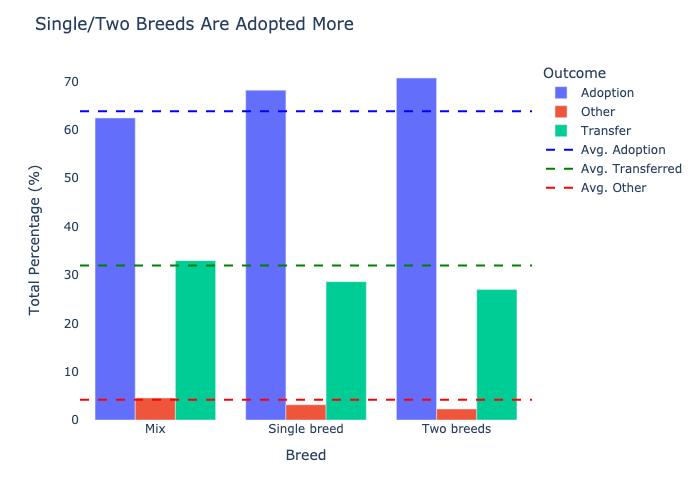

In [38]:
px_viz(train, "breed", "outcome", "Breed", 'Single/Two Breeds Are Adopted More')

In [10]:
f.chi_stats(train, "breed", "outcome")

Chi-square statistic       p-value                Decision
0            258.839347  8.111347e-55  Reject Null Hypothesis

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* There is a higher volume of mixed breeds that are not adopted or transfered
* Mixed breeds are more likely to be transfered or adopted

*Based on the result of our test and the observations in the chart, we can infer that animal breed  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q 3  Is Sex Related to Outcome?

* $Ho$ = There is no relationship between sex and outcome.
* $Ha$ = There is a relationship between sex and outcome.

In [11]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


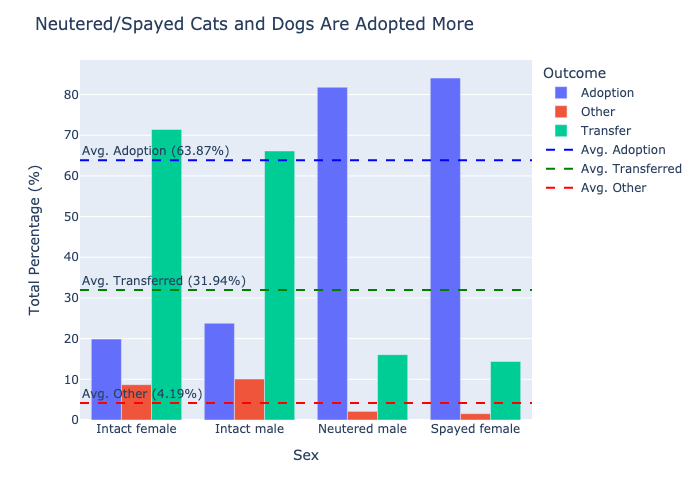

In [12]:
f.px_viz(train, "sex", "outcome", 'Sex', 'Neutered/Spayed Cats and Dogs Are Adopted More')

In [13]:
f.chi_stats(train, "sex", "outcome")

Chi-square statistic  p-value                Decision
0           23023.75966      0.0  Reject Null Hypothesis

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small.

####  Observations: 
* We can clealy observe a difference in outcomes between intact and fixed animals
    * Fixed animals are far more likely to be adopted
    * This is likly due to the common policy of animal rescues fixing animals before adoption
* Intact males are slightly more likely to have an ‘other’ outcome than intact females
* Intact females are slightly more likely to be transfered than intact males

*Based on the result of our test and the observations in the chart, we can infer that animal sex  has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q4.  Is Species Related to Outcome?

* $Ho$ = There is no relationship between species and outcome.
* $Ha$ = There is a relationship between species and outcome.

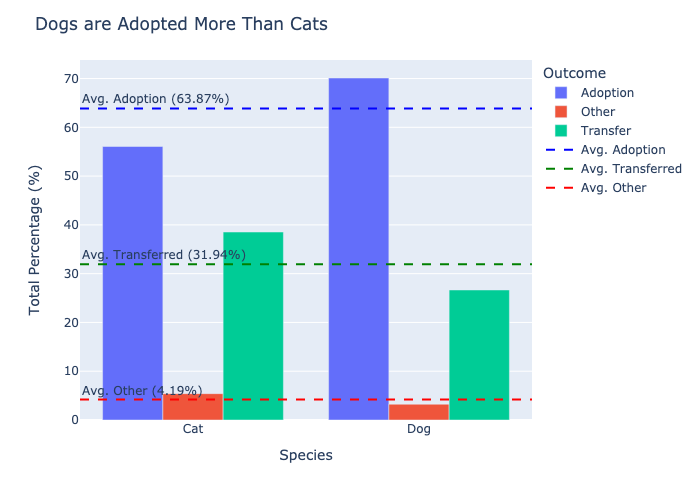

In [14]:
f.px_viz(train, "species", "outcome", 'Species', 'Dogs are Adopted More Than Cats')

In [15]:
f.chi_stats(train, "species", "outcome")

Chi-square statistic        p-value                Decision
0           1405.711162  5.671523e-306  Reject Null Hypothesis

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Among dogs a higher percentage were adopted compared to cats
29289 cats, 36758 dogs
    * ~55% of cats were adopted vs ~70% of dogs, while cats more likely to be transfered ~39% for cats, ~27% for dogs
* Cats are slightly more likely to have an ‘other’ or transfer outcome than dogs

*Based on the result of our test and the observations in the chart, we can infer that species type has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q5. Is Condition Related to Outcome?
* $Ho$ = There is no relationship between condition and outcome.
* $Ha$ = There is a relationship between condition and outcome.

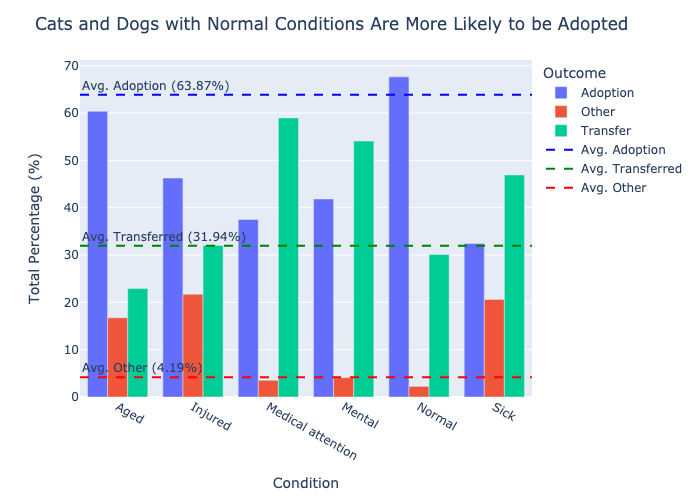

In [16]:
f.px_viz(train, "condition",
         "outcome", 'Condition',
         'Cats and Dogs with Normal Conditions Are More Likely to be Adopted')

In [17]:
f.chi_stats(train, "condition", "outcome")

Chi-square statistic  p-value                Decision
0            6845.51901      0.0  Reject Null Hypothesis

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Cats and dogs with normal conditions are more likely to be adopted.
    * Cats and dogs requiring medical attention or sick are more likely to be transferred - possibly due to outsourcing for medical needs
    * Injured Cats and dogs are more likely to be adopted.

*Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.

In [ ]:
### Q6. Is Intake Type Related to Outcome?
* $Ho$ = There is no relationship between intake_type and outcome.
* $Ha$ = There is a relationship between intake_type and outcome.

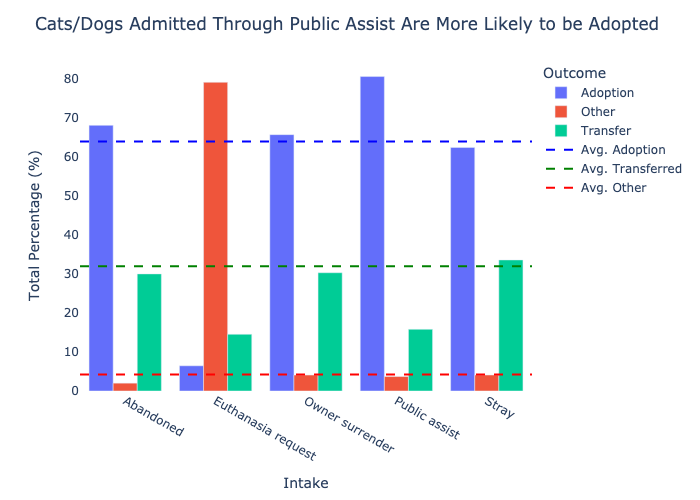

In [39]:
px_viz(train, "intake_type",
         "outcome", 'Intake',
         "Cats/Dogs Admitted Through Public Assist Are More Likely to be Adopted")

### Q6.  Is Multi-Color Coat Related to Outcome?

* $Ho$ = There is no relationship between mix_color and outcome.
* $Ha$ = There is a relationship between mix_color and outcome.

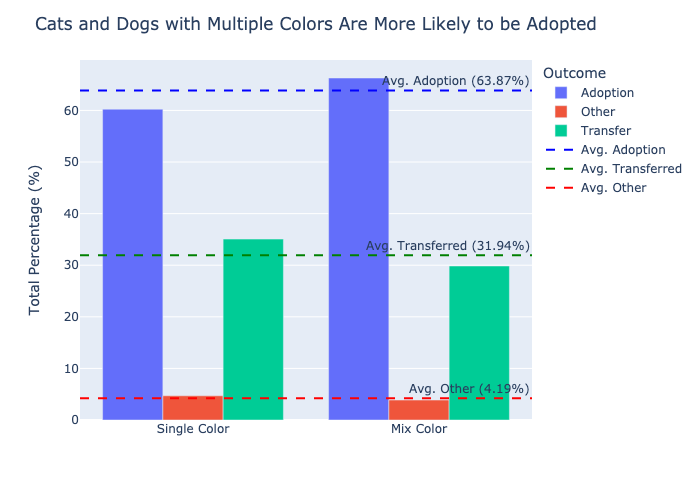

In [18]:
f.px_num_viz(train, 
           "mix_color",
           "outcome", 
           'Cats and Dogs with Multiple Colors Are More Likely to be Adopted', 
           tick_labels=["Single Color", "Mix Color"])

In [19]:
f.chi_stats(train, "mix_color", "outcome")

Chi-square statistic       p-value                Decision
0            251.848185  2.050508e-55  Reject Null Hypothesis

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Cats and dogs with normal conditions are more likely to be adopted.
    * Cats and dogs requiring medical attention or sick are more likely to be transferred - possibly due to outsourcing for medical needs
    * Injured Cats and dogs are more likely to be adopted.

*Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.

### Q7. Are Tabby Pattern Coats Related to Outcome?

* $Ho$ = There is no relationship between is_tabby and outcome.
* $Ha$ = There is a relationship between is_tabby and outcome.

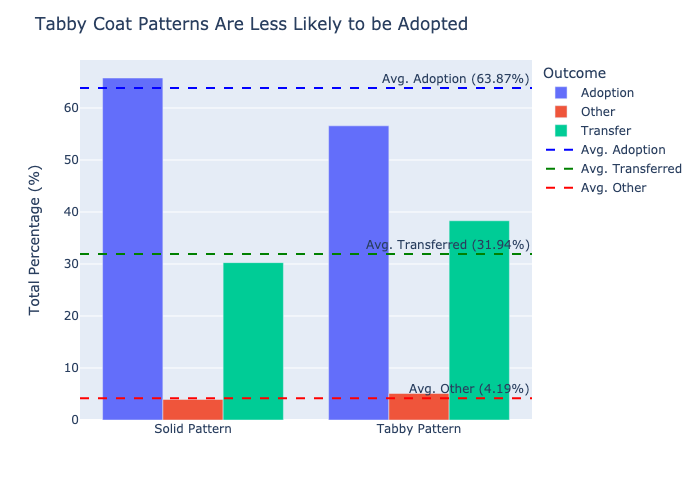

In [20]:
f.px_num_viz(train, 
           "is_tabby",
           "outcome", 
           'Tabby Coat Patterns Are Less Likely to be Adopted',
           tick_labels=["Solid Pattern", "Tabby Pattern"])

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Cats and dogs with normal conditions are more likely to be adopted.
    * Cats and dogs requiring medical attention or sick are more likely to be transferred - possibly due to outsourcing for medical needs
    * Injured Cats and dogs are more likely to be adopted.

*Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.

In [27]:
f.chi_stats(train, "is_tabby", "outcome")

Chi-square statistic       p-value                Decision
0            397.904158  3.946481e-87  Reject Null Hypothesis

### Q8.  Is Primary Coat Color Related to Outcome?

* $Ho$ = There is no relationship between primary_color and outcome.
* $Ha$ = There is a relationship between primary_color and outcome.

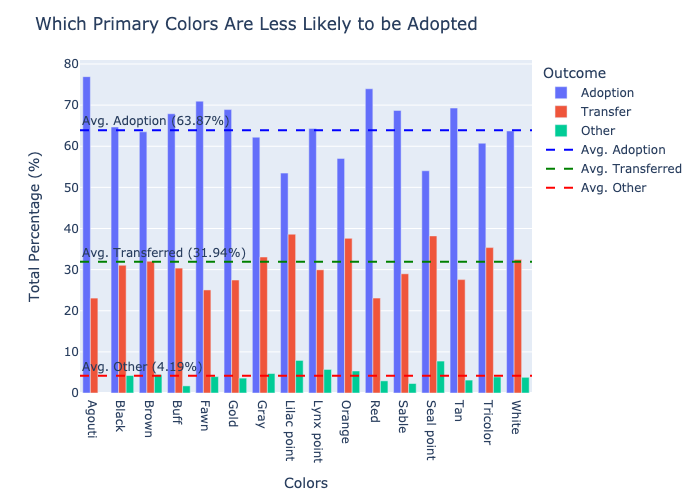

In [21]:
f.px_viz(train, "primary_color", "outcome", "Colors", 'Which Primary Colors Are Less Likely to be Adopted')

In [28]:
f.chi_stats(train, "primary_color", "outcome")

Chi-square statistic       p-value                Decision
0            317.974216  7.433311e-50  Reject Null Hypothesis

The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
The p-value is extremely small

####  Observations: 
* Cats and dogs with normal conditions are more likely to be adopted.
    * Cats and dogs requiring medical attention or sick are more likely to be transferred - possibly due to outsourcing for medical needs
    * Injured Cats and dogs are more likely to be adopted.

*Based on the result of our test and the observations in the chart, we can infer that condition has some correlation to their final outcome. Therefore, we will use this feature in our model.

## Exploration Summary


# Continuing to Modeling
- Identifed features that have a significant relationship with outcome:
    * June, July, August, and December had higher volumes
    * Mixed breeds are more likely to be transfered or adopted
    * Fixed animals are far more likely to be adopted
    * Cats are slightly more likely to have an ‘other’ or transfer outcome than dogs
    * Cats and dogs with normal conditions are more likely to be adopted.
    
- Month of outcome, Breed of species, Sex, Species, Condition, Mix_color, Month_Rel:
    * Each feature had a statistically significant relaitonship with outcome
    
# We did not move forward with the following features: 
* Year_rel: Showed overall trend and would not be a accurate prediction
* Outcome_age: Data integrity issued was raised when we found negative ages
      

## Modeling

- Evaluation Meteric: Accuracy
- Target is outcome
- Baseline: 63.3% (adopted)
- Models will be developed using a few different types, various features, and various hyperparameter configurations
    - KNN
    - Logistic Regression
    - Decision Tree Classifier
    - Random Forest Classifier
    - Support Vector Machine
- Models will be evaluated on Train and Validate
- Best performing model will only be evaluated on Test

In [22]:
# get x and y variables
x_train,y_train,x_validate,y_validate,x_test,y_test = f.get_xy(model_df, "outcome")

train -> (66047, 34), 60.0%
validate -> (22016, 34),20.0%
test -> (22016, 34), 20.0%


In [23]:
# get models - train and validate scores
f.get_models(x_train,y_train,x_validate,y_validate)

model       set  accuracy
0      k_nearest_neighbors     train  0.790800
1      k_nearest_neighbors  validate  0.789835
2      logistic_regression     train  0.794586
3      logistic_regression  validate  0.796012
4   DecisionTreeClassifier     train  0.790619
5   DecisionTreeClassifier  validate  0.791788
6            random_forest     train  0.712296
7            random_forest  validate  0.713118
8   support_vector_machine     train  0.798689
9   support_vector_machine  validate  0.797829
10             naive_bayes     train  0.677306
11             naive_bayes  validate  0.676553
12       gradient_boosting     train  0.797432
13       gradient_boosting  validate  0.797556

# Comparing Models
Baseline: 63.87
* The KNN Model yielded a train accuracy of 79.08 and a validate accuracy of 78.99
* The Logistics Regression Model yielded a train accuracy of 79.46 and a validate accuracy of 79.60
* The Decision Tree Model yielded a train accuracy of 79.06 and a validate accuracy of 79.18
* The Random Forest Model yielded a train accuracy of 71.23 and a validate accuracy of 71.31
* The Support Vector Machine Model yielded a train accuracy of 79.87 and a validate accuracy of 79.78
* The Naive Bayes Model yielded a train accuracy of 67.73 and a validate accuracy of 67.66
* The Gradient Boosting Model yielded a train accuracy of 79.74 and a validate accuracy of 79.76

# Model Selection
* The Gradient Boosting Model maintained a 79.75 % average accuracy with only a 0.02 differential in both train and validate. While most of the models did well with the exception of the Naive Bayes model, there were slight variances between the train and validate sets. We beat the baseline accuracy score of 63.87% by 15.88% when using the average of the Gradient Boosting Model. We will move forward with the Gradient Boosting Model using the final test data set.

In [24]:
f.run_gradient_boost(x_train, y_train, x_test, y_test)

model   set  accuracy
0  gradient_boosting  test  0.798919

# Model Summary
* The Gradient Boost model had a test accuracy score of 79.8%, which is approximately 16% greater than the baseline. 

## Report - Takeaways & Conclusions

### Exploration 
   * Month of outcome, Breed of species, Sex, Species, Condition, Mix_color, Month_Rel had a statistically significant relaitonship with outcome
   * Year_rel and outcome_age did not move to modeling because data integrity was an issue or would not be a accurate prediction.

 
### Recommendations
* During the high adoptions months promote cats, mixed breeds, more by reducing adoption costs, adding stories and character traits.

* We have data governance recommendations:
    - We found tens of thousands of rows with data that was missing and/or had nonsensical information
    * Collect information more information such as: 
        - Incidents (e.g. biting, abuse hx) 
        - Stated reason for return 
        - Reasons for turn in by owners
        - Vaccination status
        - Who turned the animal in (e.g. citizen, law enforcement, organization)
        - Microchipped

### Next Steps
* If provided more time we would use NLP to review the polarity of the names. 
* Review other shelters with different features